# Análisis exploratorio - SECOP I
Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los datos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Este tipo de análisis inicial permite proporcionar pistas sobre qué variables son adecuadas como predictores para un modelo.

#### Conexión a BigQuery

In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

Consulta SQL.

In [2]:
query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''

In [3]:
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset es de: {secop_I.shape[0]}\nEl número de columnas del dataset es de: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset es de: 26553
El número de columnas del dataset es de: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,...,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,...,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,...,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,...,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,...,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,...,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [4]:
# Dimensiones del dataset
# ==============================================================================
secop_I.shape

(26553, 38)

In [5]:
# Tipo de variables
# ==============================================================================
secop_I.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   uid                             26553 non-null  Int64 
 1   anno_cargue_secop               26553 non-null  Int64 
 2   id_modalidad                    26553 non-null  Int64 
 3   modalidad_de_contratacion       26553 non-null  object
 4   estado_del_proceso              26553 non-null  object
 5   id_objeto_a_contratar           26553 non-null  Int64 
 6   detalle_del_objeto_a_contratar  26553 non-null  object
 7   tipo_de_contrato                26553 non-null  object
 8   municipio_de_obtencion          26553 non-null  object
 9   municipios_ejecucion_           26553 non-null  object
 10  departamento_ejecucion          26553 non-null  object
 11  numero_de_proceso               26553 non-null  object
 12  numero_de_contrato              26553 non-null

In [38]:
#secop_I.groupby(['id_modalidad', 'modalidad_de_contratacion'])['uid'].count().sort_values(ascending=False)

id_modalidad  modalidad_de_contratacion                                            
13            contratacion minima cuantia                                              18396
12            contratacion directa ley de                                               1927
9             subasta                                                                     73
11            seleccion abreviada de menor cuantia ley de                                 72
1             licitacion publica                                                           5
18            seleccion abreviada del literal del numeral del articulo de la ley de        3
              contratacion minima cuantia                                                  0
13            contratacion directa ley de                                                  0
              licitacion publica                                                           0
              seleccion abreviada de menor cuantia ley de                      

In [7]:
# casteo de las variables
secop_I['uid'] = secop_I['uid'].astype('category')
secop_I['anno_cargue_secop'] = secop_I['anno_cargue_secop'].astype('int64')
secop_I['id_modalidad'] = secop_I['id_modalidad'].astype('category')
secop_I['modalidad_de_contratacion'] = secop_I['modalidad_de_contratacion'].astype('category')
secop_I['estado_del_proceso'] = secop_I['estado_del_proceso'].astype('category')
secop_I['id_objeto_a_contratar'] = secop_I['id_objeto_a_contratar'].astype('category')
secop_I['detalle_del_objeto_a_contratar'] = secop_I['detalle_del_objeto_a_contratar'].astype('str')
secop_I['tipo_de_contrato'] = secop_I['tipo_de_contrato'].astype('category')
secop_I['municipio_de_obtencion'] = secop_I['municipio_de_obtencion'].astype('category')
secop_I['municipios_ejecucion_'] = secop_I['municipios_ejecucion_'].astype('category')
secop_I['departamento_ejecucion'] = secop_I['departamento_ejecucion'].astype('category')
secop_I['numero_de_proceso'] = secop_I['numero_de_proceso'].astype('category')
secop_I['numero_de_contrato'] = secop_I['numero_de_contrato'].astype('category')
secop_I['cuantia_proceso'] = secop_I['cuantia_proceso'].astype('int64')
secop_I['id_grupo'] = secop_I['id_grupo'].astype('category')
secop_I['nombre_grupo'] = secop_I['nombre_grupo'].astype('category')
secop_I['id_familia'] = secop_I['id_familia'].astype('category')
secop_I['nombre_familia'] = secop_I['nombre_familia'].astype('category')
secop_I['id_clase'] = secop_I['id_clase'].astype('category')
secop_I['nombre_clase'] = secop_I['nombre_clase'].astype('category')
secop_I['id_adjudicacion'] = secop_I['id_adjudicacion'].astype('category')
secop_I['tipo_identifi_del_contratista'] = secop_I['tipo_identifi_del_contratista'].astype('category')
secop_I['identificacion_del_contratista'] = secop_I['identificacion_del_contratista'].astype('category')
secop_I['nom_razon_social_contratista'] = secop_I['nom_razon_social_contratista'].astype('category')
secop_I['tipo_doc_representante_legal'] = secop_I['tipo_doc_representante_legal'].astype('category')
secop_I['identific_representante_legal'] = secop_I['identific_representante_legal'].astype('category')
secop_I['plazo_de_ejec_del_contrato_'] = secop_I['plazo_de_ejec_del_contrato_'].astype('int64')
secop_I['dias_ejec_final_contrato'] = secop_I['dias_ejec_final_contrato'].astype('int64')
secop_I['rango_de_ejec_del_contrato'] = secop_I['rango_de_ejec_del_contrato'].astype('category')
secop_I['tiempo_adiciones_en_dias'] = secop_I['tiempo_adiciones_en_dias'].astype('int64')
secop_I['cuantia_contrato'] = secop_I['cuantia_contrato'].astype('int64')
secop_I['valor_total_de_adiciones'] = secop_I['valor_total_de_adiciones'].astype('int64')
secop_I['valor_contrato_con_adiciones'] = secop_I['valor_contrato_con_adiciones'].astype('int64')
secop_I['moneda'] = secop_I['moneda'].astype('category')
secop_I['objeto_del_contrato_a_la'] = secop_I['objeto_del_contrato_a_la'].astype('str')
secop_I['ruta_proceso_en_secop_i'] = secop_I['ruta_proceso_en_secop_i'].astype('str')

#### Distribución de la variable de respuesta

Cuando se crea un modelo, es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir.

C:\Users\Majo\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Majo\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


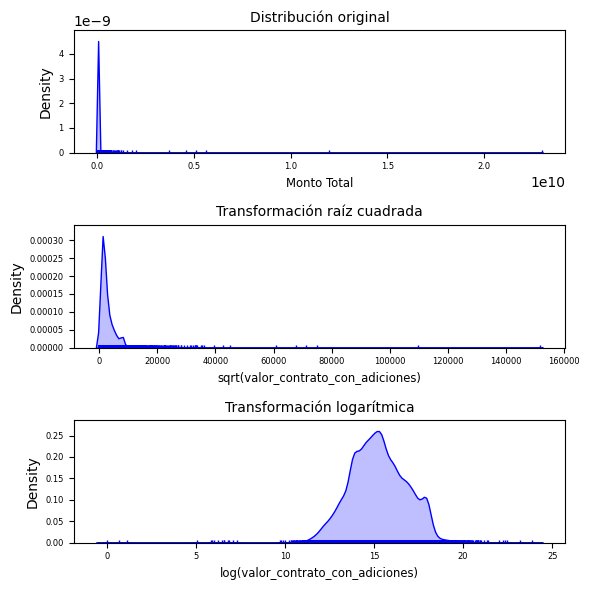

In [8]:
# Gráfico de distribución de la varaible de interés
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    secop_I.valor_contrato_con_adiciones,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    secop_I.valor_contrato_con_adiciones,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize='medium')
axes[0].set_xlabel('Monto Total', fontsize='small') 
axes[0].tick_params(labelsize=6)

sns.kdeplot(
    np.sqrt(secop_I.valor_contrato_con_adiciones),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(secop_I.valor_contrato_con_adiciones),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize='medium')
axes[1].set_xlabel('sqrt(valor_contrato_con_adiciones)', fontsize='small') 
axes[1].tick_params(labelsize=6)

sns.kdeplot(
    np.log(secop_I.valor_contrato_con_adiciones),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(secop_I.valor_contrato_con_adiciones),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize='medium')
axes[2].set_xlabel('log(valor_contrato_con_adiciones)', fontsize='small') 
axes[2].tick_params(labelsize=6)

fig.tight_layout()

<Axes: >

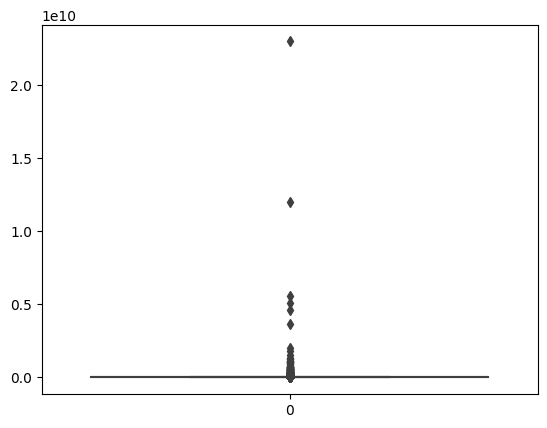

In [9]:
# Prubea de outliers con Box Plot
sns.boxplot(secop_I['valor_contrato_con_adiciones'])

Se evidencia outliers en la variable de interés. Por lo tanto estos serán eliminados antes de realizar cualquier otro tipo de análisis.

In [10]:
# Tratamiento de outliers
Q1 = np.percentile(secop_I['valor_contrato_con_adiciones'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(secop_I['valor_contrato_con_adiciones'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", secop_I.shape)
 
# Upper bound
upper = Q3+1.5*IQR
upper_array = secop_I.loc[secop_I['valor_contrato_con_adiciones']>=upper].index.to_list()

# Lower bound
lower = Q1-1.5*IQR
lower_array = secop_I.loc[secop_I['valor_contrato_con_adiciones']<=lower].index.to_list()

# Removing the outliers
secop_I.drop(upper_array, inplace=True)
secop_I.drop(lower_array, inplace=True)
secop_I.reset_index(drop=True, inplace=True)
 
print("New Shape: ", secop_I.shape)

Old Shape:  (26553, 38)
New Shape:  (23054, 38)


C:\Users\Majo\AppData\Local\Temp\ipykernel_14824\3534246938.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(secop_I['valor_contrato_con_adiciones'], 25,
C:\Users\Majo\AppData\Local\Temp\ipykernel_14824\3534246938.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(secop_I['valor_contrato_con_adiciones'], 75,


C:\Users\Majo\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Majo\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


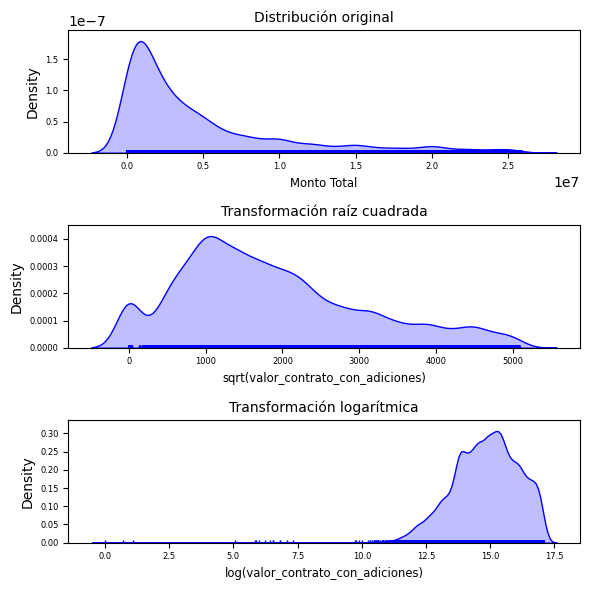

In [11]:
# Gráfico de distribución de la varaible de interés despues de eliminación de outliers
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    secop_I.valor_contrato_con_adiciones,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    secop_I.valor_contrato_con_adiciones,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize='medium')
axes[0].set_xlabel('Monto Total', fontsize='small') 
axes[0].tick_params(labelsize=6)

sns.kdeplot(
    np.sqrt(secop_I.valor_contrato_con_adiciones),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(secop_I.valor_contrato_con_adiciones),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize='medium')
axes[1].set_xlabel('sqrt(valor_contrato_con_adiciones)', fontsize='small') 
axes[1].tick_params(labelsize=6)

sns.kdeplot(
    np.log(secop_I.valor_contrato_con_adiciones),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(secop_I.valor_contrato_con_adiciones),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize='medium')
axes[2].set_xlabel('log(valor_contrato_con_adiciones)', fontsize='small') 
axes[2].tick_params(labelsize=6)

fig.tight_layout()

<Axes: >

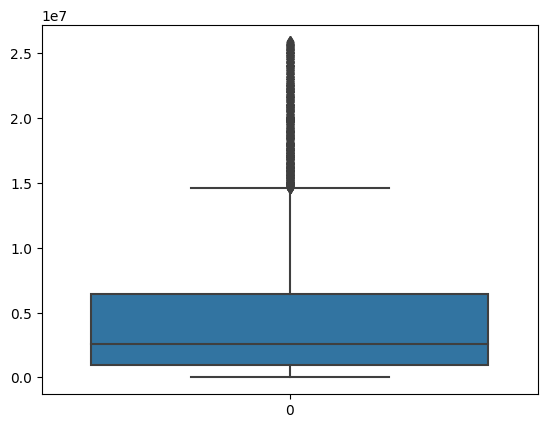

In [12]:
# Prubea de outliers con Box Plot
sns.boxplot(secop_I['valor_contrato_con_adiciones'])

In [13]:
# Ajuste a distribuciones
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(secop_I.valor_contrato_con_adiciones, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

Fitting 9 distributions: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,3.054731e-14,3658.597965,-948989.949005,0.067632,0.076215,6.497221e-117
beta,5.294051e-14,3523.731456,-936302.685602,0.106637,0.131050,0.000000e+00
exponpow,5.493618e-14,3528.302871,-935459.660169,0.100819,0.145167,0.000000e+00
expon,7.467201e-14,3614.399117,-928393.665687,0.105511,0.102488,2.785585e-211
cauchy,1.756631e-13,3744.723673,-908671.825772,0.200169,0.237195,0.000000e+00
logistic,2.612289e-13,3716.077850,-899523.332352,0.340541,0.209513,0.000000e+00
chi2,2.995504e-13,3669.767916,-896357.528969,0.427257,0.195484,0.000000e+00
norm,3.016380e-13,3666.194120,-896207.463523,0.431749,0.197975,0.000000e+00
powerlaw,3.715466e-13,3997.050095,-891391.885270,0.214554,0.821995,0.000000e+00


#### Variables numéricas

In [14]:
# Variables numéricas
# ==============================================================================
secop_I.select_dtypes(include=['float64', 'int']).describe()

,anno_cargue_secop,cuantia_proceso,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones
count,23054.00000,2.305400e+04,23054.000000,23054.000000,23054.0,23054.000000,2.305400e+04,23054.0,2.305400e+04,2.305400e+04
mean,2016.01388,8.933925e+06,70.402793,71.112822,0.019953,0.710029,4.728987e+06,0.085712,1.458441e+05,4.874831e+06
std,0.90511,3.792574e+07,137.151432,137.681937,0.139842,7.196580,5.555614e+06,0.279944,7.491546e+05,5.742813e+06
min,2015.00000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,2015.00000,1.271092e+06,13.000000,15.000000,0.0,0.000000,9.425750e+05,0.0,0.000000e+00,9.650550e+05
50%,2016.00000,3.500000e+06,30.000000,30.000000,0.0,0.000000,2.519350e+06,0.0,0.000000e+00,2.600000e+06
75%,2017.00000,9.281425e+06,90.000000,90.000000,0.0,0.000000,6.193750e+06,0.0,0.000000e+00,6.400710e+06
max,2019.00000,4.850000e+09,7500.000000,7500.000000,1.0,230.000000,2.586000e+07,1.0,1.754450e+07,2.586000e+07


De la anterior tabla, es posible observar que:

* El último año de cargue de los contratos fue del `2019` así como tambien elprimer año con el que se cuenta es a partir del `2015` (más adelante se explicará se decidió tomar hasta este año).
* *** El `plazo` máximo de ejecución fue de `7,500 días` posible outlier dentro del dataset. 
* El `tiempo` máximo `de adiciones en días` es de `230 días`.

Text(0.5, 0.98, 'Distribución variables numéricas')

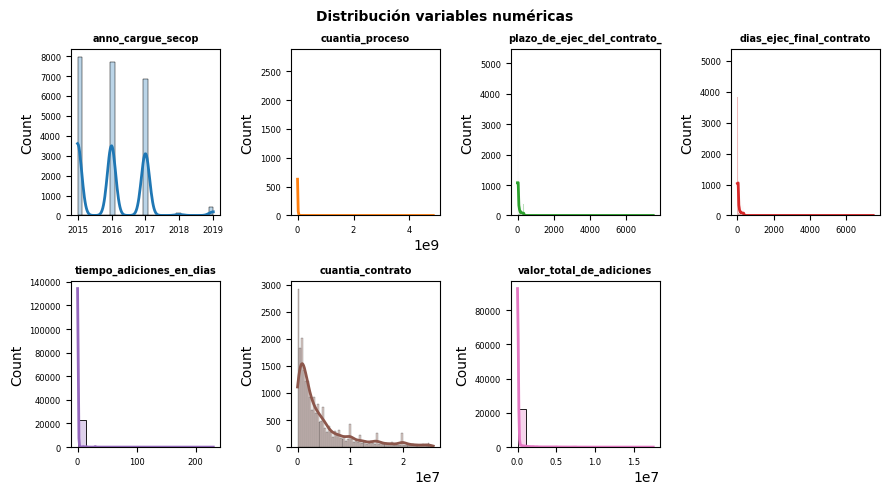

In [15]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5))
axes = axes.flat
columnas_numeric = secop_I.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop(['valor_contrato_con_adiciones', 'prorrogado', 'con_adicion_pptal'])

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = secop_I,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")

Como se puede evicdenciar en las anteriores gráficas para las varias de las varaibles se puede observar outliers. Al igaul que la variable *valor_contrato_con_adiciones*, para la varible *dias_ejec_final_contrato* se realizará el tratamiento de outliers adecuado para eliminación dicho efecto, ya que esta resulta ser una variable de interés y de la cual se cree que puede inferir de manera significativa para la predicción de la variable de interés. 

In [16]:
# Tratamiento de outliers
Q1 = np.percentile(secop_I['dias_ejec_final_contrato'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(secop_I['dias_ejec_final_contrato'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", secop_I.shape)
 
# Upper bound
upper = Q3+1.5*IQR
upper_array = secop_I.loc[secop_I['dias_ejec_final_contrato']>=upper].index.to_list()

# Lower bound
lower = Q1-1.5*IQR
lower_array = secop_I.loc[secop_I['dias_ejec_final_contrato']<=lower].index.to_list()

# Removing the outliers
secop_I.drop(upper_array, inplace=True)
secop_I.drop(lower_array, inplace=True)
secop_I.reset_index(drop=True, inplace=True)
 
print("New Shape: ", secop_I.shape)

Old Shape:  (23054, 38)
New Shape:  (20476, 38)


C:\Users\Majo\AppData\Local\Temp\ipykernel_14824\2772767032.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(secop_I['dias_ejec_final_contrato'], 25,
C:\Users\Majo\AppData\Local\Temp\ipykernel_14824\2772767032.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(secop_I['dias_ejec_final_contrato'], 75,


<Axes: >

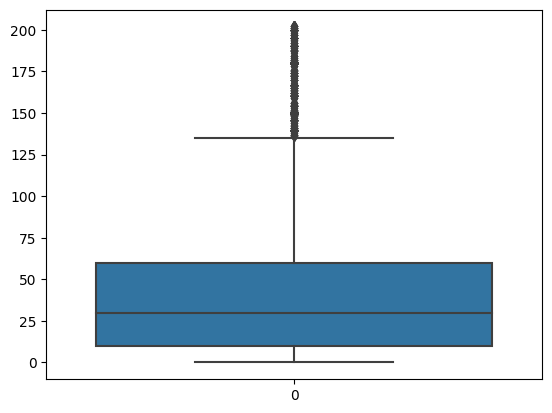

In [17]:
# Prubea de outliers con Box Plot
sns.boxplot(secop_I['dias_ejec_final_contrato'])

Text(0.5, 0.98, 'Correlación con el monto total')

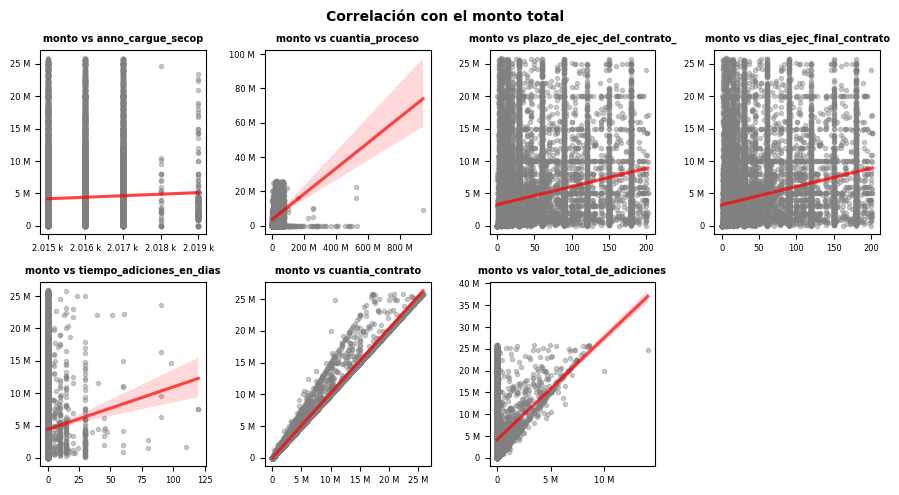

In [18]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5))
axes = axes.flat
columnas_numeric = secop_I.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop(['valor_contrato_con_adiciones', 'prorrogado', 'con_adicion_pptal'])

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = secop_I[colum],
        y           = secop_I['valor_contrato_con_adiciones'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"monto vs {colum}", fontsize=7, fontweight="bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [7]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con el monto total', fontsize = 10, fontweight = "bold")

#### Correlación variables númericas

In [19]:
# Correlación entre columnas numéricas
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2', 'r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = secop_I.drop(['prorrogado', 'con_adicion_pptal'], axis=1)
corr_matrix = corr_matrix.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix)

,variable_1,variable_2,r,abs_r
26,dias_ejec_final_contrato,plazo_de_ejec_del_contrato_,0.997138,0.997138
19,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,0.997138,0.997138
47,cuantia_contrato,valor_contrato_con_adiciones,0.994546,0.994546
61,valor_contrato_con_adiciones,cuantia_contrato,0.994546,0.994546
41,cuantia_contrato,cuantia_proceso,0.284118,0.284118
13,cuantia_proceso,cuantia_contrato,0.284118,0.284118
57,valor_contrato_con_adiciones,cuantia_proceso,0.283481,0.283481
15,cuantia_proceso,valor_contrato_con_adiciones,0.283481,0.283481
55,valor_total_de_adiciones,valor_contrato_con_adiciones,0.245488,0.245488
62,valor_contrato_con_adiciones,valor_total_de_adiciones,0.245488,0.245488


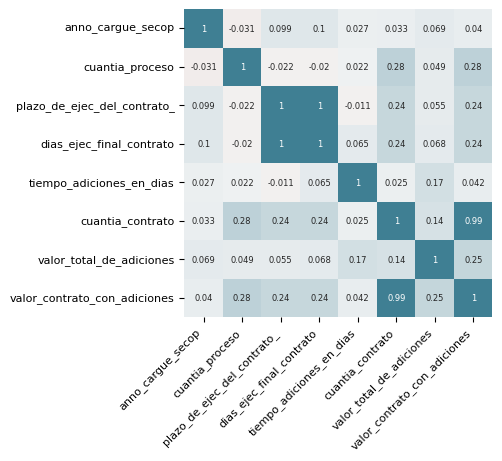

In [20]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize=8)

Del correlograma anterior, se puede concluir que las variables *dias_ejec_final_contrato* y *plazo_de_ejec_del_contrato_* tienen una correlación 1 positivo por lo cual incluirlas en simultaneo dentro de los modelos resultaría en problema de multicolinealidad. Este misma situación presenta las varibales *valor_contrato_con_adiciones* y *cuantia_contrato*. Por lo tanto, las variables *plazo_de_ejec_del_contrato_* y *cuantia_contrato* serán eliminadas, esto a razón de que tanto los *dias_ejec_final_contrato* como *valor_contrato_con_adiciones* son las variables que contienen el total de estos valores. Asimismo, se decidé eliminar la varibale del año pues para fines del modelo esta variable no es de interés estudiarla.

In [21]:
secop_I.drop(['anno_cargue_secop', 'plazo_de_ejec_del_contrato_', 'cuantia_contrato'], axis=1, inplace=True)

#### Variables cualitativas

In [22]:
# Variables cualitativas (tipo object)
# ==============================================================================
secop_I.select_dtypes(include=['category', 'object']).describe()

,uid,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,...,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,rango_de_ejec_del_contrato,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
count,20476,20476,20476,20476,20476,20476,20476,20476,20476,20476,...,20476,20476,20476,20476,20476,20471,20476,20476,20476,20476
unique,20476,6,6,7,56,16023,10,191,199,31,...,19071,6,5915,6817,7,5271,2,3,16163,18929
top,151145605,13,contratacion minima cuantia,celebrado,50000000,productos alimenticios expendio,compraventa,acacias,acacias,antioquia,...,Sin Adjudicar,nit de persona juridica,No Definido,no definido,cedula de ciudadania,No Definido,D,peso colombiano,productos alimenticios expendio,{'url': 'https://www.contratos.gov.co/consulta...
freq,1,18396,18396,10417,3859,72,8553,1639,1668,2424,...,1406,9325,1406,1406,18739,1406,19070,20375,71,15


Asimismo, para el siguiente análisis se filtrarán las columnas que son de interés de estudio, pues existe varias de ellas que son informativas o redundantes entre ellas mismas. (MOSTRAR CORRELACIONES ENTRE GRUPO, FAMILIA Y CLASE / DEPARTAMENTO Y MUNICIPIO / MOSTRAR LA CALIDAD DE DATOS DE IDETIFICACION DEL CONTRATISTA / MOSTRAR QUE PRORROGADO Y ADICION PRESUPUESTAL NO SON VARIABLES SIGNIFICATIVAS)

In [23]:
columnas_object = secop_I.select_dtypes(include=['category', 'object']).columns
columnas_object

Index(['uid', 'id_modalidad', 'modalidad_de_contratacion',
       'estado_del_proceso', 'id_objeto_a_contratar',
       'detalle_del_objeto_a_contratar', 'tipo_de_contrato',
       'municipio_de_obtencion', 'municipios_ejecucion_',
       'departamento_ejecucion', 'numero_de_proceso', 'numero_de_contrato',
       'id_grupo', 'nombre_grupo', 'id_familia', 'nombre_familia', 'id_clase',
       'nombre_clase', 'id_adjudicacion', 'tipo_identifi_del_contratista',
       'identificacion_del_contratista', 'nom_razon_social_contratista',
       'tipo_doc_representante_legal', 'identific_representante_legal',
       'rango_de_ejec_del_contrato', 'moneda', 'objeto_del_contrato_a_la',
       'ruta_proceso_en_secop_i'],
      dtype='object')

In [24]:
secop_I_filter = secop_I.drop(['uid', 'modalidad_de_contratacion', 'municipio_de_obtencion', 'municipios_ejecucion_',
                                'numero_de_proceso', 'numero_de_contrato', 'nombre_grupo', 'id_familia', 
                                'nombre_familia', 'id_clase', 'nombre_clase', 'id_adjudicacion', 'tipo_identifi_del_contratista',
                                'tipo_identifi_del_contratista', 'identificacion_del_contratista', 'nom_razon_social_contratista',
                                'tipo_doc_representante_legal', 'identific_representante_legal',
                                'rango_de_ejec_del_contrato', 'moneda', 'objeto_del_contrato_a_la',
                                'ruta_proceso_en_secop_i', 'prorrogado', 'con_adicion_pptal'], axis=1)
secop_I_filter.columns

Index(['id_modalidad', 'estado_del_proceso', 'id_objeto_a_contratar',
       'detalle_del_objeto_a_contratar', 'tipo_de_contrato',
       'departamento_ejecucion', 'cuantia_proceso', 'id_grupo',
       'dias_ejec_final_contrato', 'tiempo_adiciones_en_dias',
       'valor_total_de_adiciones', 'valor_contrato_con_adiciones'],
      dtype='object')

In [25]:
secop_I_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20476 entries, 0 to 20475
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id_modalidad                    20476 non-null  category
 1   estado_del_proceso              20476 non-null  category
 2   id_objeto_a_contratar           20476 non-null  category
 3   detalle_del_objeto_a_contratar  20476 non-null  object  
 4   tipo_de_contrato                20476 non-null  category
 5   departamento_ejecucion          20476 non-null  category
 6   cuantia_proceso                 20476 non-null  int64   
 7   id_grupo                        20476 non-null  category
 8   dias_ejec_final_contrato        20476 non-null  int64   
 9   tiempo_adiciones_en_dias        20476 non-null  int64   
 10  valor_total_de_adiciones        20476 non-null  int64   
 11  valor_contrato_con_adiciones    20476 non-null  int64   
dtypes: category(6), in

Text(0.5, 0.98, 'Distribución variables cualitativas')

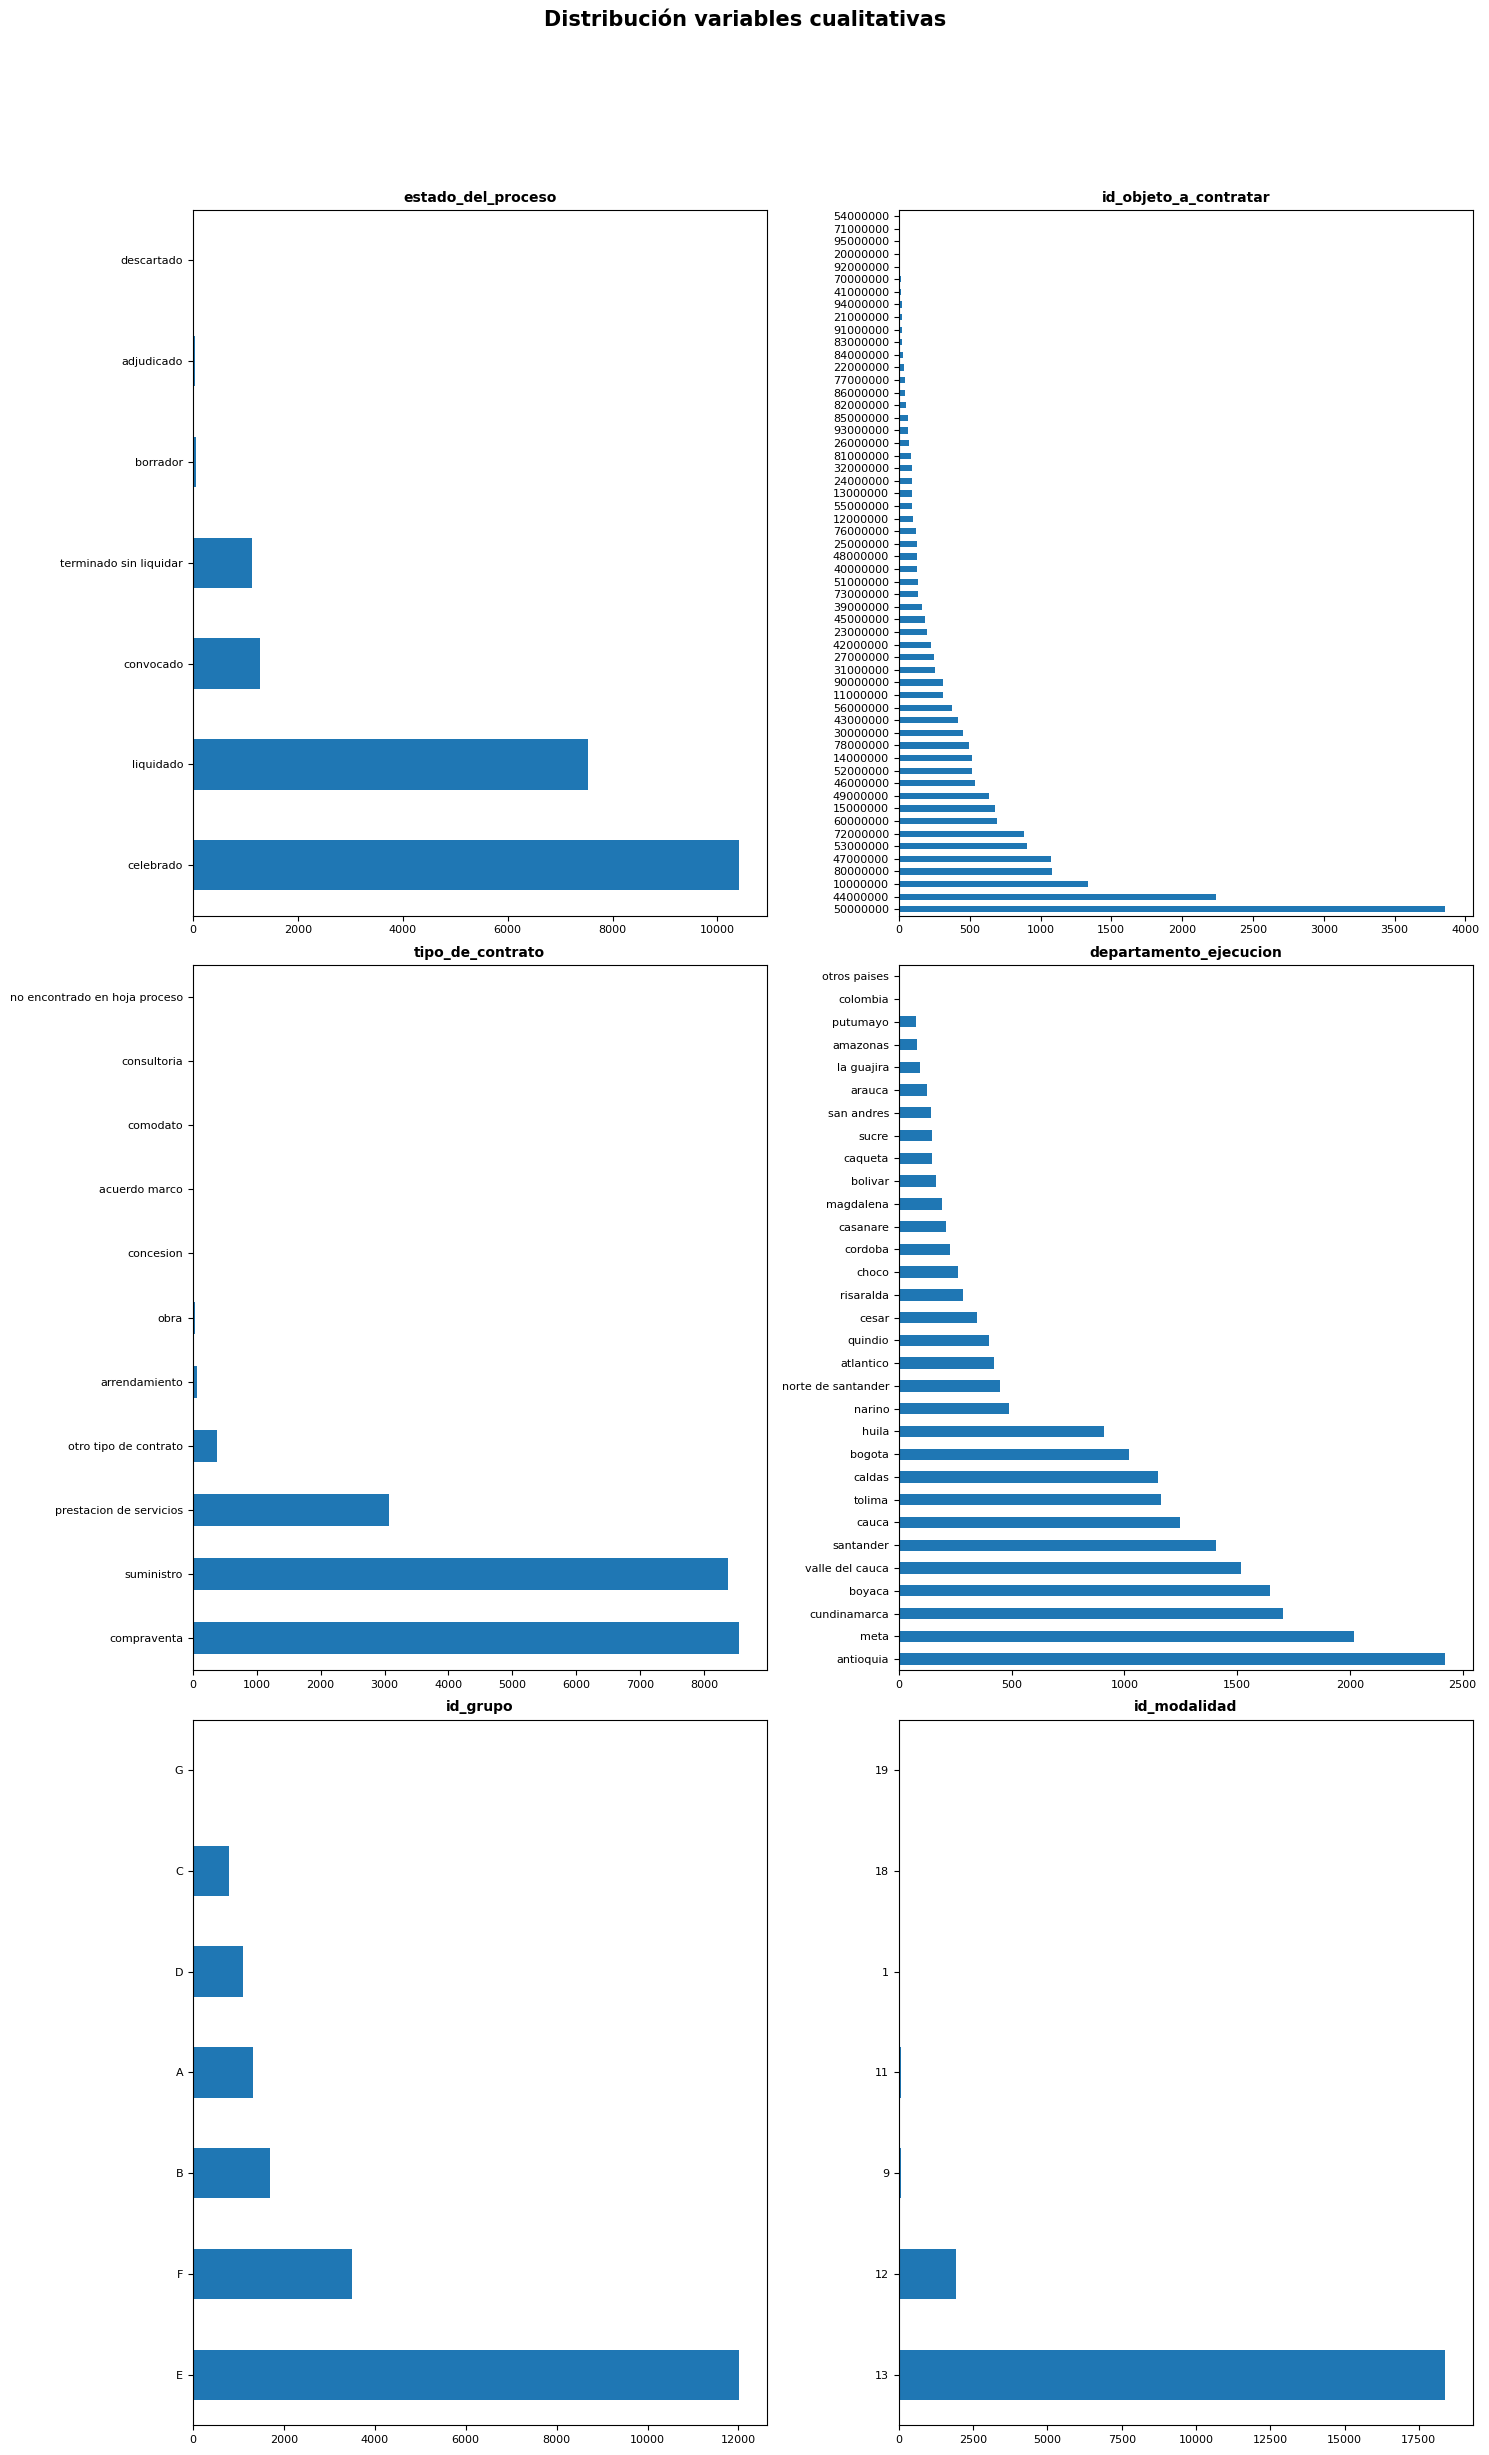

In [35]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 25))
axes = axes.flat
columnas_object = secop_I_filter.select_dtypes(include=['category']).columns

for i, colum in enumerate(columnas_object):
    secop_I[colum].value_counts().plot.barh(ax=axes[i-1])
    axes[i-1].set_title(colum, fontsize=10, fontweight="bold")
    axes[i-1].tick_params(labelsize=8)
    axes[i-1].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize=15, fontweight="bold")